## **Project Task 2.3: Signal Interpolation (Jupyter Notebook)**

This notebook implements and compares signal downsampling followed by reconstruction using various interpolation methods (manual linear, SciPy linear, SciPy cubic).

**Objective:** To understand the effects of downsampling and interpolation on a signal in both the time and frequency domains.

**Methodology:**

1. Generate a test signal.  
2. Downsample the signal.  
3. Reconstruct the signal using different interpolation techniques (including a manual implementation).  
4. Analyze the results visually (time/frequency plots) and quantitatively (MSE).

**Libraries Used:**

* numpy for numerical operations.  
* matplotlib for plotting.  
* scipy.interpolate for standard interpolation functions.  
* scipy.fft for Fast Fourier Transform calculations.  
* time for performance comparison.  
* typing for type hints.

Let's start by importing the necessary libraries and defining the configuration parameters.

In [1]:
# -*- coding: utf-8 -*-
"""
Cell 1: Imports and Configuration

Import necessary libraries and define configuration parameters
for the signal generation, downsampling, and interpolation process.
"""

import time
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from scipy.fft import fft, fftfreq
from typing import Tuple, Dict, Callable, Any, List

# --- Configuration ---

# Encapsulate configuration parameters in a dictionary for clarity
config: Dict[str, Any] = {
    "sampling_rate_original": 1000,  # Hz (Original sampling frequency)
    "signal_duration": 1.0,          # seconds
    "down_sampling_factor": 5,       # Must be an integer > 1
    "signal_frequencies": [50, 120], # Hz (List of frequencies for components)
    "signal_amplitudes": [1.0, 0.5], # Amplitudes for each frequency component
    "interpolation_methods": {       # Define methods to test
        # Display Name : Internal Function Key
        "Manual Linear": 'manual_linear',
        "SciPy Linear": 'scipy_linear',
        "SciPy Cubic": 'scipy_cubic'
    }
}

print("Cell 1 executed: Libraries imported and configuration set.")
# Verify configuration
# print(config)


Cell 1 executed: Libraries imported and configuration set.


### **Signal Generation**
This function creates the original test signal, which is composed of multiple sine waves based on the frequencies and amplitudes defined in the configuration.

In [2]:
# -*- coding: utf-8 -*-
"""
Cell 2: Signal Generation Function

Defines the function to generate the original test signal.
"""
from typing import List, Tuple
import numpy as np # Ensure numpy is imported if running cells independently

def generate_signal(sampling_rate: int, duration: float, frequencies: List[float], amplitudes: List[float]) -> Tuple[np.ndarray, np.ndarray]:
    """
    Generates a sample signal composed of multiple sine wave components.

    Args:
        sampling_rate: The sampling frequency in Hz.
        duration: The duration of the signal in seconds.
        frequencies: A list of frequencies for the sine components.
        amplitudes: A list of amplitudes corresponding to each frequency.

    Returns:
        A tuple containing:
            - time_vector: Time points for the signal (shape: [n_samples,]).
            - signal: The generated signal values (shape: [n_samples,]).

    Raises:
        ValueError: If the lengths of frequencies and amplitudes do not match.
    """
    if len(frequencies) != len(amplitudes):
        raise ValueError("Lengths of frequencies and amplitudes must match.")

    num_samples = int(sampling_rate * duration)
    time_vector = np.linspace(0, duration, num_samples, endpoint=False)
    signal = np.zeros(num_samples)

    # Add each sine component
    for freq, amp in zip(frequencies, amplitudes):
        signal += amp * np.sin(2 * np.pi * freq * time_vector)

    print(f"Function 'generate_signal' defined.")
    # Example usage (optional, will be called in main execution)
    # t_test, s_test = generate_signal(100, 1.0, [5, 15], [1, 0.5])
    # print(f"Test signal generated with {len(s_test)} samples.")
    return time_vector, signal

print("Cell 2 executed: 'generate_signal' function defined.")


Cell 2 executed: 'generate_signal' function defined.


### **Signal Processing Functions**

These functions handle the core signal processing steps:

* **downsample\_signal**: Reduces the sampling rate of the signal.  
* **manual\_linear\_interpolate**: Performs linear interpolation manually.  
* **scipy\_interpolate**: A wrapper for SciPy's interpolation functions.  
* **reconstruct\_signal**: Selects and applies the chosen interpolation method.

In [3]:
# -*- coding: utf-8 -*-
"""
Cell 3: Signal Processing Functions

Defines functions for downsampling and interpolation (manual and SciPy-based).
"""
import time
import numpy as np # Ensure numpy is imported
from scipy.interpolate import interp1d # Ensure scipy is imported
from typing import Tuple, Dict, Callable, Any, List # Ensure typing is imported

def downsample_signal(signal: np.ndarray, time_vector: np.ndarray, factor: int) -> Tuple[np.ndarray, np.ndarray, float]:
    """
    Downsamples the signal by selecting every 'factor'-th sample.

    Args:
        signal: The original signal values.
        time_vector: The original time vector.
        factor: The integer downsampling factor (> 1).

    Returns:
        A tuple containing:
            - time_vector_downsampled: Time points for the downsampled signal.
            - signal_downsampled: The downsampled signal values.
            - new_sampling_rate: The effective sampling rate after downsampling.

    Raises:
        ValueError: If factor is not an integer greater than 1.
    """
    if not isinstance(factor, int) or factor <= 1:
        raise ValueError("Downsampling factor must be an integer greater than 1.")

    signal_downsampled = signal[::factor]
    time_vector_downsampled = time_vector[::factor]
    # Calculate original sampling rate robustly
    if len(time_vector) > 1:
         dt = time_vector[1] - time_vector[0]
         original_sampling_rate = 1.0 / dt if dt > 0 else 0
    else:
         original_sampling_rate = 0 # Or handle as an error/warning

    new_sampling_rate = original_sampling_rate / factor
    print(f"Downsampled signal by factor {factor}. Original SR: {original_sampling_rate:.2f} Hz, New SR: {new_sampling_rate:.2f} Hz.")
    print(f"Downsampled signal has {len(signal_downsampled)} samples.")
    return time_vector_downsampled, signal_downsampled, new_sampling_rate

def manual_linear_interpolate(t_down: np.ndarray, s_down: np.ndarray, t_orig: np.ndarray) -> np.ndarray:
    """
    Performs manual linear interpolation. (Implementation as before)
    """
    s_recon = np.zeros_like(t_orig)
    indices = np.searchsorted(t_down, t_orig, side='right')

    for i, t in enumerate(t_orig):
        idx = indices[i]
        if idx == 0:
            s_recon[i] = s_down[0] # Handle beginning edge case
        elif idx == len(t_down):
            s_recon[i] = s_down[-1] # Handle end edge case
        else:
            x1, y1 = t_down[idx - 1], s_down[idx - 1]
            x2, y2 = t_down[idx], s_down[idx]
            # Avoid division by zero if time points are identical
            dx = x2 - x1
            if dx != 0:
                s_recon[i] = y1 + (t - x1) * (y2 - y1) / dx
            else:
                s_recon[i] = y1 # Assign value from the coincident point
    return s_recon

def scipy_interpolate(t_down: np.ndarray, s_down: np.ndarray, t_orig: np.ndarray, kind: str) -> np.ndarray:
    """
    Performs interpolation using scipy.interpolate.interp1d. (Implementation as before)
    """
    interpolation_function = interp1d(t_down, s_down, kind=kind, bounds_error=False, fill_value=0) # Use fill_value=0 for points outside original range
    return interpolation_function(t_orig)

def reconstruct_signal(t_down: np.ndarray, s_down: np.ndarray, t_orig: np.ndarray, method_key: str) -> np.ndarray:
    """
    Reconstructs the signal using the specified interpolation method key.
    """
    print(f"Reconstructing signal using '{method_key}' interpolation...")
    start_time = time.time()

    if method_key == 'manual_linear':
        s_recon = manual_linear_interpolate(t_down, s_down, t_orig)
    elif method_key == 'scipy_linear':
        s_recon = scipy_interpolate(t_down, s_down, t_orig, kind='linear')
    elif method_key == 'scipy_cubic':
        s_recon = scipy_interpolate(t_down, s_down, t_orig, kind='cubic')
    else:
        raise ValueError(f"Unknown interpolation method key: {method_key}")

    end_time = time.time()
    print(f"Finished '{method_key}' interpolation in {end_time - start_time:.4f} seconds.")
    return s_recon

print("Cell 3 executed: Signal processing functions defined.")



Cell 3 executed: Signal processing functions defined.


### **Analysis Functions**

These functions are used to quantitatively evaluate the reconstruction results:

* **calculate\_fft**: Computes the Fast Fourier Transform to analyze frequency content.  
* **calculate\_mse**: Calculates the Mean Squared Error to measure the difference between the original and reconstructed signals.

In [4]:
# -*- coding: utf-8 -*-
"""
Cell 4: Analysis Functions

Defines functions for calculating FFT and Mean Squared Error (MSE).
"""
import numpy as np # Ensure numpy is imported
from scipy.fft import fft, fftfreq # Ensure fft is imported
from typing import Tuple # Ensure typing is imported

def calculate_fft(signal: np.ndarray, sampling_rate: float) -> Tuple[np.ndarray, np.ndarray]:
    """
    Calculates the magnitude FFT of a signal. (Implementation as before)
    """
    N = len(signal)
    if N == 0 or sampling_rate <= 0: # Add check for valid sampling rate
        print("Warning: Cannot calculate FFT for empty signal or non-positive sampling rate.")
        return np.array([]), np.array([])

    yf = fft(signal)
    xf = fftfreq(N, 1 / sampling_rate)

    # Find indices of non-negative frequencies
    positive_freq_indices = np.where(xf >= 0)[0] # Get indices directly

    # Handle potential empty result if N=1 or other edge cases
    if len(positive_freq_indices) == 0:
        return np.array([]), np.array([])

    frequencies = xf[positive_freq_indices]
    # Scale magnitude (standard scaling for single-sided spectrum)
    magnitude = np.abs(yf[positive_freq_indices]) / N
    # Double the magnitude for non-DC and non-Nyquist frequencies
    non_dc_nyquist_mask = (frequencies > 0) & (frequencies < sampling_rate / 2.0)
    magnitude[non_dc_nyquist_mask] *= 2

    return frequencies, magnitude


def calculate_mse(signal_original: np.ndarray, signal_reconstructed: np.ndarray) -> float:
    """
    Calculates the Mean Squared Error between two signals. (Implementation as before)
    """
    if len(signal_original) != len(signal_reconstructed):
        raise ValueError("Signals must have the same length to calculate MSE.")
    if len(signal_original) == 0:
        return 0.0 # Or NaN, depending on desired behavior for empty signals
    return np.mean((signal_original - signal_reconstructed)**2)

print("Cell 4 executed: Analysis functions defined.")


Cell 4 executed: Analysis functions defined.


### **Plotting Functions**

These functions generate the visualizations:

* plot\_time\_domain\_comparison: Compares signals in the time domain.  
* plot\_frequency\_domain\_comparison: Compares signals in the frequency domain using their FFT spectra.

In [5]:
# -*- coding: utf-8 -*-
"""
Cell 5: Plotting Functions

Defines functions for visualizing the results in time and frequency domains.
"""
import numpy as np # Ensure numpy is imported
import matplotlib.pyplot as plt # Ensure matplotlib is imported
from typing import Dict # Ensure typing is imported

# Make sure the analysis function is available if running cells independently
# from Cell_4_Analysis_Functions import calculate_fft # Assuming Cell 4 is run

def plot_time_domain_comparison(t_orig: np.ndarray, s_orig: np.ndarray,
                                t_down: np.ndarray, s_down: np.ndarray,
                                reconstructed_signals: Dict[str, np.ndarray],
                                downsampling_factor: int):
    """
    Plots the original, downsampled, and reconstructed signals in the time domain.
    (Implementation as before, slightly adjusted layout)
    """
    num_methods = len(reconstructed_signals)
    num_cols = 2
    # Calculate rows needed: 1 for original/downsampled + rows for methods
    num_rows = 1 + (num_methods + num_cols - 1) // num_cols # Add 1 for the first plot row
    plt.figure(figsize=(7 * num_cols, 4 * num_rows)) # Adjusted figsize

    # --- Plot 1: Original Signal and Downsampled Points ---
    ax1 = plt.subplot(num_rows, num_cols, (1, num_cols)) # Span the first row
    ax1.plot(t_orig, s_orig, label='Original Signal', color='blue', alpha=0.8, linewidth=1.5)
    ax1.plot(t_down, s_down, 'ro', label=f'Downsampled (Factor={downsampling_factor})', markersize=5)
    ax1.set_title('Original Signal & Downsampled Points')
    ax1.set_xlabel('Time [s]')
    ax1.set_ylabel('Amplitude')
    ax1.legend()
    ax1.grid(True)

    # --- Plot subsequent: Reconstructed Signals ---
    plot_index_offset = num_cols # Start plotting methods from the second row (index num_cols + 1)
    colors = plt.cm.viridis(np.linspace(0.1, 0.9, num_methods)) # Use a good colormap range
    linestyles = ['--', ':', '-.']

    for i, (method_name, s_recon) in enumerate(reconstructed_signals.items()):
        ax = plt.subplot(num_rows, num_cols, plot_index_offset + i + 1)
        ax.plot(t_orig, s_orig, label='Original', color='blue', alpha=0.15, linewidth=1) # Faint original
        ax.plot(t_orig, s_recon, label=f'Recon ({method_name})', color=colors[i], linestyle=linestyles[i % len(linestyles)], linewidth=1.5)
        ax.plot(t_down, s_down, 'ro', markersize=3, alpha=0.4) # Show downsampled points faintly
        ax.set_title(f'Reconstruction: {method_name}')
        ax.set_xlabel('Time [s]')
        ax.set_ylabel('Amplitude')
        ax.legend()
        ax.grid(True)

    plt.suptitle('Time Domain Comparison of Interpolation Methods', fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout to prevent overlap
    plt.show()


def plot_frequency_domain_comparison(s_orig: np.ndarray,
                                     reconstructed_signals: Dict[str, np.ndarray],
                                     sampling_rate: int):
    """
    Plots the frequency spectra (FFT) of the original and reconstructed signals.
    (Implementation as before, using calculate_fft)
    """
    num_signals = 1 + len(reconstructed_signals)
    plt.figure(figsize=(10, 4 * num_signals)) # Adjusted figsize
    plot_index = 1

    # --- Plot FFT of Original Signal ---
    freq_orig, mag_orig = calculate_fft(s_orig, sampling_rate)
    if len(freq_orig) > 0: # Check if FFT was successful
        ax_orig = plt.subplot(num_signals, 1, plot_index)
        ax_orig.plot(freq_orig, mag_orig, label='Original Signal', color='blue', linewidth=1.5)
        # Use stem plot for potentially better visualization of discrete frequencies
        # ax_orig.stem(freq_orig, mag_orig, linefmt='blue', markerfmt='bo', basefmt=' ', label='Original Signal')
        ax_orig.set_title('Frequency Spectrum (Original)')
        ax_orig.set_xlabel('Frequency [Hz]')
        ax_orig.set_ylabel('Magnitude')
        ax_orig.set_xlim(0, sampling_rate / 2)
        ax_orig.set_ylim(bottom=0)
        ax_orig.legend()
        ax_orig.grid(True)
        plot_index += 1
    else:
        print("Skipping FFT plot for original signal due to calculation issues.")


    # --- Plot FFT of Reconstructed Signals ---
    colors = plt.cm.viridis(np.linspace(0.1, 0.9, len(reconstructed_signals)))
    for i, (method_name, s_recon) in enumerate(reconstructed_signals.items()):
        freq_recon, mag_recon = calculate_fft(s_recon, sampling_rate)
        if len(freq_recon) > 0: # Check if FFT was successful
            ax = plt.subplot(num_signals, 1, plot_index)
            ax.plot(freq_recon, mag_recon, label=f'Recon ({method_name})', color=colors[i], linewidth=1.5)
            # ax.stem(freq_recon, mag_recon, linefmt=f'{colors[i]}-', markerfmt=f'{colors[i]}o', basefmt=' ', label=f'Recon ({method_name})')
            ax.set_title(f'Frequency Spectrum ({method_name})')
            ax.set_xlabel('Frequency [Hz]')
            ax.set_ylabel('Magnitude')
            ax.set_xlim(0, sampling_rate / 2)
            ax.set_ylim(bottom=0)
            ax.legend()
            ax.grid(True)
            plot_index += 1
        else:
             print(f"Skipping FFT plot for {method_name} due to calculation issues.")

    plt.suptitle('Frequency Domain Comparison of Interpolation Methods', fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout
    plt.show()

print("Cell 5 executed: Plotting functions defined.")


Cell 5 executed: Plotting functions defined.


Now we execute the main workflow. First, generate the original signal and then downsample it according to the configuration.

In [6]:
# -*- coding: utf-8 -*-
"""
Cell 6: Main Execution - Setup

Generate the original signal and perform downsampling.
Requires functions from Cells 1, 2, 3 to be defined.
"""
import numpy as np # Ensure numpy is imported
# Assumes config is defined in Cell 1
# Assumes generate_signal is defined in Cell 2
# Assumes downsample_signal is defined in Cell 3

print("--- Starting Main Execution ---")

# --- Generate Original Signal ---
# Make sure config is accessible (might need to re-run Cell 1 if kernel restarted)
try:
    t_original, signal_original = generate_signal(
        config["sampling_rate_original"],
        config["signal_duration"],
        config["signal_frequencies"],
        config["signal_amplitudes"]
    )
    print(f"Original signal generated: {len(signal_original)} samples.")
except NameError as e:
    print(f"Error: Required function or variable not defined. Did you run previous cells? Details: {e}")
    # Stop execution or handle appropriately
    raise

# --- Downsample ---
try:
    t_downsampled, signal_downsampled, fs_new = downsample_signal(
        signal_original, t_original, config["down_sampling_factor"]
    )
    print(f"Signal downsampled. New sampling rate: {fs_new:.2f} Hz.")
except NameError as e:
    print(f"Error: Required function or variable not defined. Did you run previous cells? Details: {e}")
    raise

print("\nCell 6 executed: Original signal generated and down1sampled.")

# Optional: Plot original and downsampled here for intermediate check
# import matplotlib.pyplot as plt
# plt.figure(figsize=(12, 4))
# plt.plot(t_original, signal_original, label='Original', alpha=0.7)
# plt.plot(t_downsampled, signal_downsampled, 'o-', label='Downsampled', markersize=4)
# plt.title("Original vs Downsampled Signal")
# plt.xlabel("Time [s]")
# plt.ylabel("Amplitude")
# plt.legend()
# plt.grid(True)
# plt.show()



--- Starting Main Execution ---
Function 'generate_signal' defined.
Original signal generated: 1000 samples.
Downsampled signal by factor 5. Original SR: 1000.00 Hz, New SR: 200.00 Hz.
Downsampled signal has 200 samples.
Signal downsampled. New sampling rate: 200.00 Hz.

Cell 6 executed: Original signal generated and down1sampled.


Iterate through the interpolation methods defined in the configuration and reconstruct the signal for each method. Store the results.

In [7]:
# -*- coding: utf-8 -*-
"""
Cell 7: Main Execution - Reconstruction

Reconstruct the signal using the different interpolation methods defined in config.
Requires variables from Cell 6 and functions from Cell 3.
"""
import numpy as np # Ensure numpy is imported
from typing import Dict # Ensure typing is imported
# Assumes config is defined in Cell 1
# Assumes reconstruct_signal is defined in Cell 3
# Assumes t_downsampled, signal_downsampled, t_original exist from Cell 6

print("--- Reconstructing Signals ---")
reconstructed_signals: Dict[str, np.ndarray] = {} # Initialize dictionary to store results

# Make sure necessary variables exist
if 't_downsampled' not in locals() or 'signal_downsampled' not in locals() or 't_original' not in locals():
     print("Error: Downsampled or original signal data not found. Run Cell 6 first.")
else:
    # Iterate through methods defined in the config dictionary
    for display_name, method_key in config["interpolation_methods"].items():
        try:
            # Call the reconstruction function using the method key
            reconstructed_signals[display_name] = reconstruct_signal(
                t_downsampled, signal_downsampled, t_original, method_key
            )
            print(f"Signal reconstructed using {display_name} ({method_key}).")
        except NameError as e:
            print(f"Error: Required function 'reconstruct_signal' not defined? Details: {e}")
            break # Stop if function is missing
        except ValueError as e:
            print(f"Error during reconstruction with {display_name}: {e}")
            # Continue to next method or break, depending on desired behavior
            continue

print(f"\nCell 7 executed: {len(reconstructed_signals)} signal(s) reconstructed.")
# print(f"Reconstructed signals available: {list(reconstructed_signals.keys())}")



--- Reconstructing Signals ---
Reconstructing signal using 'manual_linear' interpolation...
Finished 'manual_linear' interpolation in 0.0016 seconds.
Signal reconstructed using Manual Linear (manual_linear).
Reconstructing signal using 'scipy_linear' interpolation...
Finished 'scipy_linear' interpolation in 0.0005 seconds.
Signal reconstructed using SciPy Linear (scipy_linear).
Reconstructing signal using 'scipy_cubic' interpolation...
Finished 'scipy_cubic' interpolation in 0.0006 seconds.
Signal reconstructed using SciPy Cubic (scipy_cubic).

Cell 7 executed: 3 signal(s) reconstructed.


Calculate the Mean Squared Error (MSE) for each reconstructed signal compared to the original signal. Print the results.

In [8]:
# -*- coding: utf-8 -*-
"""
Cell 8: Main Execution - Analysis

Calculate and print the Mean Squared Error (MSE) for each reconstruction method.
Requires variables from Cell 6 & 7 and functions from Cell 4.
"""
import numpy as np # Ensure numpy is imported
from typing import Dict # Ensure typing is imported
# Assumes calculate_mse is defined in Cell 4
# Assumes signal_original exists from Cell 6
# Assumes reconstructed_signals exists from Cell 7

print("\n--- Analysis Results (MSE) ---")
mse_results: Dict[str, float] = {} # Initialize dictionary for MSE results

# Check if required data is available
if 'signal_original' not in locals():
    print("Error: Original signal not found. Run Cell 6 first.")
elif 'reconstructed_signals' not in locals() or not reconstructed_signals:
     print("Error: No reconstructed signals found. Run Cell 7 first.")
else:
    # Iterate through the reconstructed signals and calculate MSE
    for display_name, signal_recon in reconstructed_signals.items():
        try:
            mse = calculate_mse(signal_original, signal_recon)
            mse_results[display_name] = mse
            print(f"MSE ({display_name}): {mse:.6f}")
        except NameError as e:
            print(f"Error: Required function 'calculate_mse' not defined? Details: {e}")
            break # Stop if function is missing
        except ValueError as e:
            print(f"Error calculating MSE for {display_name}: {e}")
            continue # Continue with the next method

print("\nCell 8 executed: MSE calculated.")
# print(f"MSE results: {mse_results}")




--- Analysis Results (MSE) ---
MSE (Manual Linear): 0.132403
MSE (SciPy Linear): 0.135981
MSE (SciPy Cubic): 0.177646

Cell 8 executed: MSE calculated.


Visualize the results by calling the plotting functions to compare the signals in the time and frequency domains.


--- Generating Plots ---
Generating time domain plot...


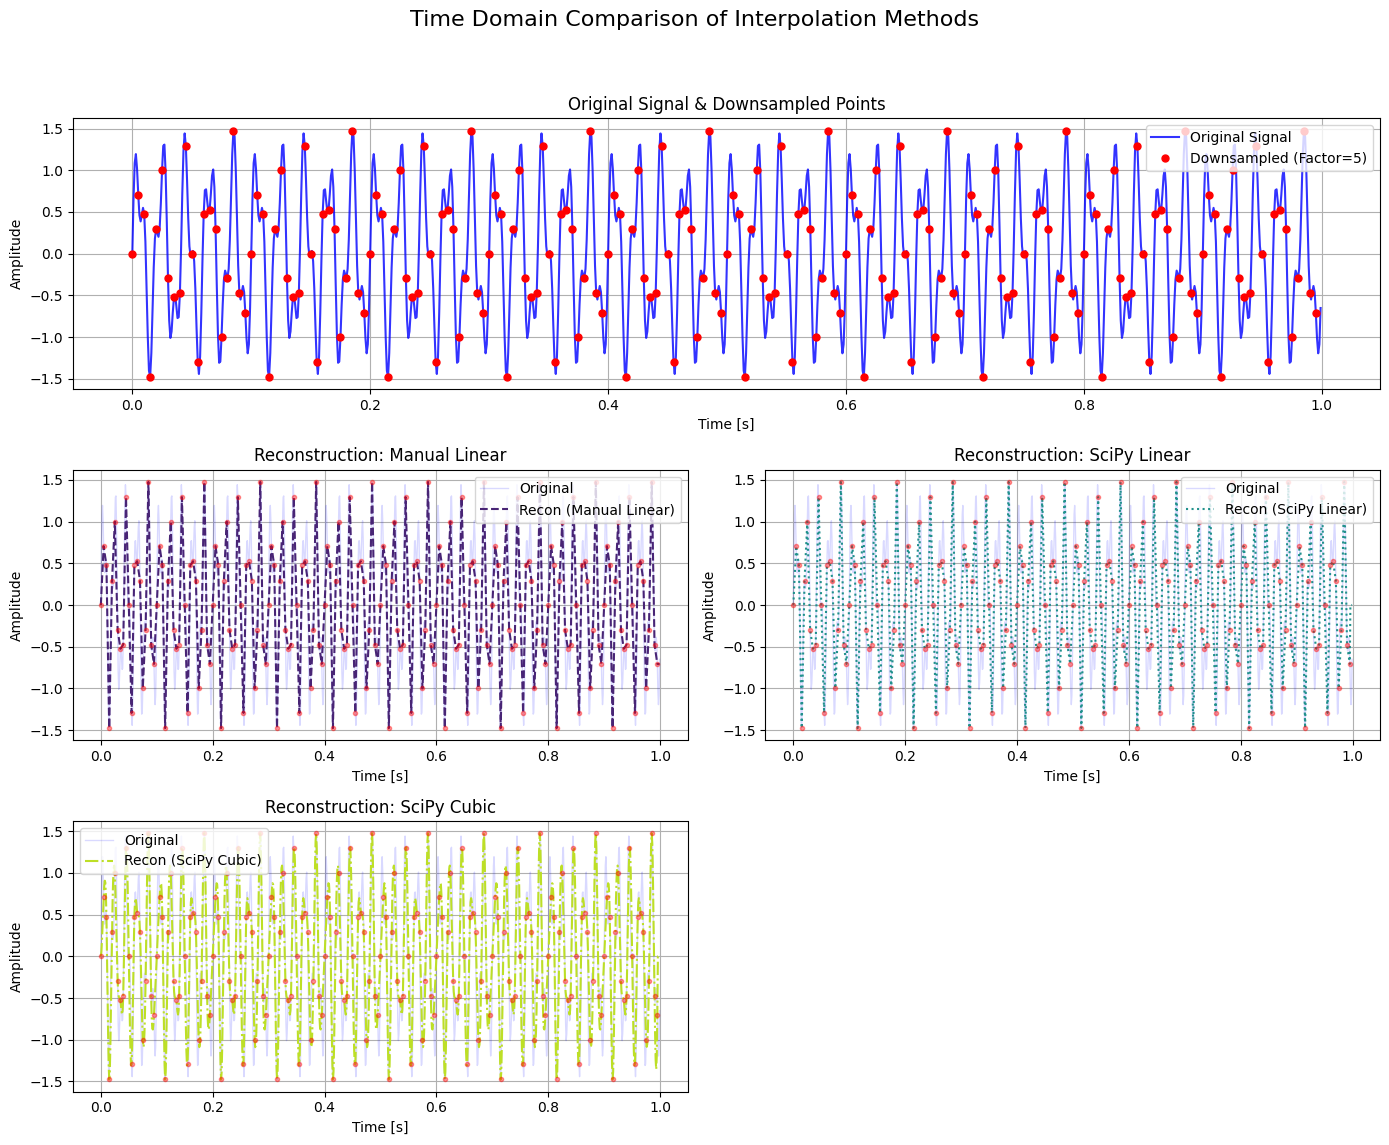

Time domain plot generated.
Generating frequency domain plot...


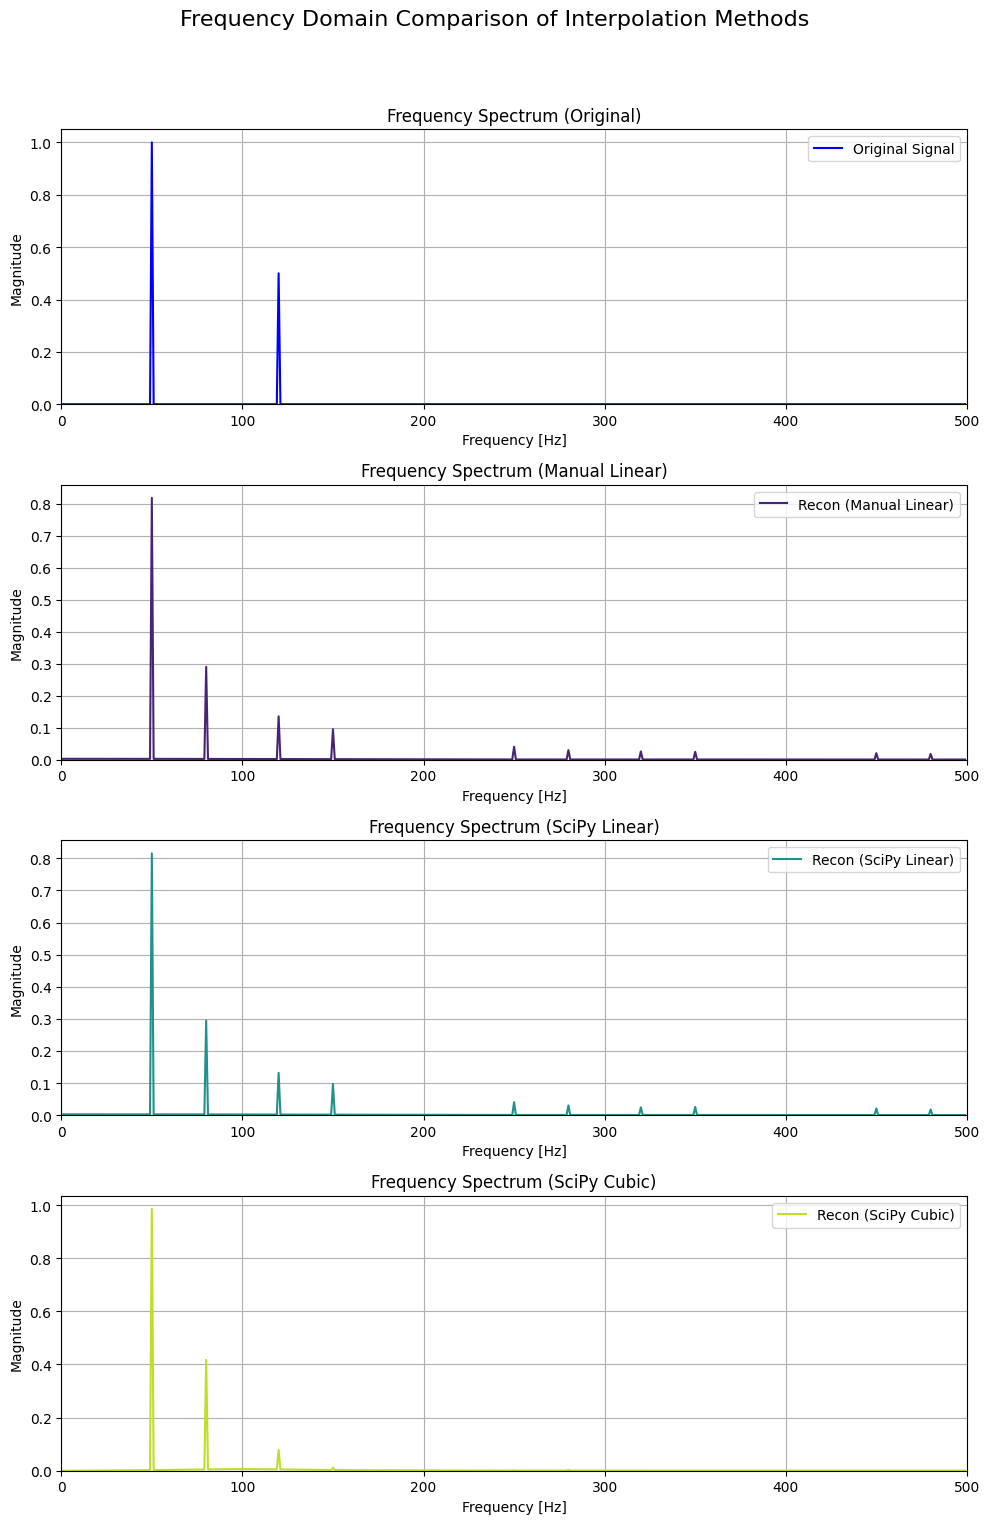

Frequency domain plot generated.

Cell 9 executed: Plotting complete (if data and functions were available).


In [9]:
# -*- coding: utf-8 -*-
"""
Cell 9: Main Execution - Plotting

Generate plots comparing the signals in time and frequency domains.
Requires variables from Cell 6 & 7 and functions from Cell 5.
"""
# Assumes plot_time_domain_comparison and plot_frequency_domain_comparison are defined in Cell 5
# Assumes t_original, signal_original, t_downsampled, signal_downsampled exist from Cell 6
# Assumes reconstructed_signals exists from Cell 7
# Assumes config exists from Cell 1

print("\n--- Generating Plots ---")

# Check if required data and functions are available
plot_time_func_exists = 'plot_time_domain_comparison' in locals()
plot_freq_func_exists = 'plot_frequency_domain_comparison' in locals()
data_exists = ('t_original' in locals() and
               'signal_original' in locals() and
               't_downsampled' in locals() and
               'signal_downsampled' in locals() and
               'reconstructed_signals' in locals() and
               reconstructed_signals) # Check if dict is not empty

if not plot_time_func_exists:
    print("Error: 'plot_time_domain_comparison' function not defined. Run Cell 5.")
if not plot_freq_func_exists:
    print("Error: 'plot_frequency_domain_comparison' function not defined. Run Cell 5.")
if not data_exists:
     print("Error: Required signal data not found. Run Cells 6 and 7 first.")

# Proceed only if everything is ready
if plot_time_func_exists and plot_freq_func_exists and data_exists:
    try:
        # --- Plot Time Domain ---
        print("Generating time domain plot...")
        plot_time_domain_comparison(
            t_original, signal_original,
            t_downsampled, signal_downsampled,
            reconstructed_signals,
            config["down_sampling_factor"]
        )
        print("Time domain plot generated.")

        # --- Plot Frequency Domain ---
        print("Generating frequency domain plot...")
        plot_frequency_domain_comparison(
            signal_original,
            reconstructed_signals,
            config["sampling_rate_original"]
        )
        print("Frequency domain plot generated.")

    except Exception as e:
        print(f"An error occurred during plotting: {e}")

print("\nCell 9 executed: Plotting complete (if data and functions were available).")



Finally, print some key observations and points that should be considered for the project documentation, based on the results obtained.

In [10]:
# -*- coding: utf-8 -*-
"""
Cell 10: Main Execution - Documentation Notes

Print key observations and points relevant for project documentation.
Requires variables from Cell 1 and Cell 6.
"""
# Assumes config exists from Cell 1
# Assumes fs_new exists from Cell 6

print("\n--- Key Observations & Documentation Points ---")

# Check if required variables exist
config_exists = 'config' in locals()
fs_new_exists = 'fs_new' in locals()

if not config_exists:
    print("Error: Configuration dictionary 'config' not found. Run Cell 1.")
if not fs_new_exists:
    print("Error: Downsampled sampling rate 'fs_new' not found. Run Cell 6.")

if config_exists and fs_new_exists:
    original_nyquist = config['sampling_rate_original'] / 2
    downsampled_nyquist = fs_new / 2
    frequencies_above_limit = [f for f in config['signal_frequencies'] if f > downsampled_nyquist]

    print(f"* Original Sampling Rate: {config['sampling_rate_original']} Hz, Original Nyquist Frequency: {original_nyquist} Hz")
    print(f"* Downsampled Sampling Rate: {fs_new:.2f} Hz, Downsampled Nyquist Frequency: {downsampled_nyquist:.2f} Hz")

    if frequencies_above_limit:
        print(f"* Signal components above new Nyquist limit ({downsampled_nyquist:.2f} Hz): {frequencies_above_limit} Hz")
        print("* -> Expect aliasing: Frequencies above the new Nyquist limit will fold back into the spectrum.")
    else:
        print(f"* All original signal components are below the new Nyquist limit ({downsampled_nyquist:.2f} Hz).")
        print("* -> Aliasing due to downsampling itself should be minimal for these components.")

    print("\n* Time Domain Observations:")
    print("    * Compare the visual smoothness of reconstructed signals (Cubic is typically smoother than Linear).")
    print("    * Note how linear interpolation connects points with straight lines, potentially creating sharp 'corners'.")
    print("    * Observe how well each method approximates the original signal shape between the downsampled points.")

    print("\n* Frequency Domain Observations:")
    print("    * Compare the frequency spectra of reconstructed signals to the original.")
    print("    * Look for attenuation of higher frequencies (common with simpler interpolation).")
    print("    * Identify any aliased components (frequencies appearing where they shouldn't be due to folding).")
    print("    * Assess how well cubic interpolation preserves the original frequency magnitudes compared to linear.")

    print("\n* Quantitative Analysis:")
    print("    * Compare the Mean Squared Error (MSE) values calculated in Cell 8. Lower MSE indicates better reconstruction accuracy.")
    print("    * Relate MSE values to the visual quality observed in the time/frequency plots.")

    print("\n* Performance:")
    print("    * Note the execution times printed during reconstruction (Cell 7) for manual vs. SciPy methods.")
    print("    * SciPy's optimized implementations are expected to be significantly faster.")

    print("\n* Conclusion Points:")
    print("    * Discuss the trade-offs between interpolation methods (accuracy vs. computational cost, smoothness).")
    print("    * Explain the impact of the downsampling factor and the Nyquist theorem on reconstruction quality.")
    print("    * Summarize which method performed best for this specific signal and parameters, and why.")

else:
    print("Could not print all documentation notes because some required variables were missing.")

print("\nCell 10 executed: Documentation notes printed.")



--- Key Observations & Documentation Points ---
* Original Sampling Rate: 1000 Hz, Original Nyquist Frequency: 500.0 Hz
* Downsampled Sampling Rate: 200.00 Hz, Downsampled Nyquist Frequency: 100.00 Hz
* Signal components above new Nyquist limit (100.00 Hz): [120] Hz
* -> Expect aliasing: Frequencies above the new Nyquist limit will fold back into the spectrum.

* Time Domain Observations:
    * Compare the visual smoothness of reconstructed signals (Cubic is typically smoother than Linear).
    * Note how linear interpolation connects points with straight lines, potentially creating sharp 'corners'.
    * Observe how well each method approximates the original signal shape between the downsampled points.

* Frequency Domain Observations:
    * Compare the frequency spectra of reconstructed signals to the original.
    * Look for attenuation of higher frequencies (common with simpler interpolation).
    * Identify any aliased components (frequencies appearing where they shouldn't be due